<a href="https://colab.research.google.com/github/rohitm487/Causal_Inference_in_Python/blob/main/6_Causal_Inference_Causal_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.9 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from econml.grf import CausalForest
import seaborn as sns


In [10]:

# Step 1: Simulate data or load your dataset
def simulate_causal_forest_data(n=1000):
    np.random.seed(0)
    X = np.random.randn(n, 5)  # control variables
    registration_source = np.random.choice(['Instagram', 'Twitter', 'Bing'], size=n)
    treatment = np.random.binomial(1, 0.5, size=n)  # binary treatment variable
    outcome = 1 + 2 * treatment + np.dot(X, np.random.randn(5)) + np.random.randn(n)
    return pd.DataFrame(X, columns=[f'X{i}' for i in range(5)]), pd.Series(registration_source, name="Registration.Source"), pd.Series(treatment, name="Treatment"), pd.Series(outcome, name="Outcome")

X, registration_source, treatment, outcome = simulate_causal_forest_data()


In [11]:
# One-hot encoding for categorical variables (Registration Source)
encoder = OneHotEncoder(sparse_output=False)
registration_source_encoded = encoder.fit_transform(registration_source.values.reshape(-1, 1))
registration_df = pd.DataFrame(registration_source_encoded, columns=encoder.categories_[0])


In [12]:

# Merge the dataset with the registration source data
data = pd.concat([X, registration_df, treatment, outcome], axis=1)


In [13]:

# Step 2: Fit OLS model (Outcome ~ Treatment + Controls)
X_ols = sm.add_constant(pd.concat([X, treatment], axis=1))
ols_model1 = sm.OLS(outcome, X_ols).fit()


In [14]:

# Step 3: Fit OLS model with interaction terms (Outcome ~ Treatment * Registration Source)
X_interactions = X_ols.copy()
for col in registration_df.columns:
    X_interactions[f"Treatment x {col}"] = treatment * registration_df[col]

ols_model2 = sm.OLS(outcome, X_interactions).fit()


In [15]:

# Step 4: Compare OLS Models
print("OLS Model 1 (Without Interactions):")
print(ols_model1.summary())

print("\nOLS Model 2 (With Interactions):")
print(ols_model2.summary())


OLS Model 1 (Without Interactions):
                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     873.2
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:23:25   Log-Likelihood:                -1434.0
No. Observations:                1000   AIC:                             2882.
Df Residuals:                     993   BIC:                             2916.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [16]:

# Step 5: Fit Causal Forest
causal_forest = CausalForest(n_estimators=1000, min_samples_leaf=5, max_depth=None)
causal_forest.fit(X.values, treatment.values, outcome.values)


CausalForest(n_estimators=1000)

In [17]:

# Step 6: Obtain Causal Forest Predictions
predictions = causal_forest.predict(X.values)


In [19]:
# Step 7: Analyze Heterogeneous Treatment Effects by Registration Source
df_predictions = pd.DataFrame({'pred': predictions.flatten(), 'Registration.Source': registration_source})
mean_pred_by_source = df_predictions.groupby('Registration.Source')['pred'].mean()

print("\nMean predicted treatment effect by registration source:")
print(mean_pred_by_source)


Mean predicted treatment effect by registration source:
Registration.Source
Bing         2.012681
Instagram    2.026604
Twitter      2.008991
Name: pred, dtype: float64


In [20]:

# Step 8: Variable Importance
importance = causal_forest.feature_importances_
importance_df = pd.DataFrame({'variable': X.columns, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print("\nVariable Importance:")
print(importance_df)




Variable Importance:
  variable  importance
0       X0    0.516841
3       X3    0.253521
2       X2    0.140552
4       X4    0.046952
1       X1    0.042134


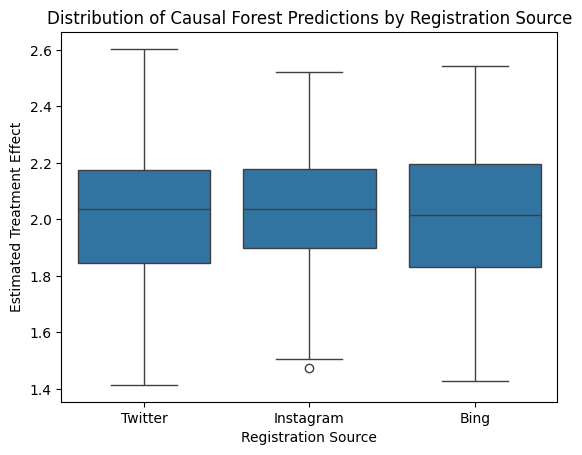

In [21]:
# Step 9: Visualize Causal Forest Predictions by Registration Source
sns.boxplot(x='Registration.Source', y='pred', data=df_predictions)
plt.xlabel("Registration Source")
plt.ylabel("Estimated Treatment Effect")
plt.title("Distribution of Causal Forest Predictions by Registration Source")
plt.show()